In [1]:
import pandas as pd
import xtrack as xt
import numpy as np
import BBStudies.Tracking.Utils as xutils



def get_bblr_bbcw_df(config_file):

    config = xutils.read_YAML(config_file)


    # Default locations
    # ----------------------------
    beam_list = ['b1', 'b2']
    loc_list  = ['4l1','4r1','4l5','4r5']
    ip_list   = ['ip1', 'ip5']
    tank_list = ['a', 'b', 'c']
    # ----------------------------

        # Parameters
    #-------------------------------------
    seq         = config['sequence']
    ip_name     = config['ip']
    disable_ho  = config['disable_ho']
    # as_wires    = True

    beam_name = seq[-2:]
    s_marker  = config['s_marker']
    e_marker  = config['e_marker']
    #-------------------------------------


    # Loading collider
    #-------------------------------------
    collider    = xt.Multiline.from_json(config['collider_path'])
    line0       = collider[seq]

    # Collimation emittance
    #---------------------------
    nemitt_x = 2.5e-6
    nemitt_y = 2.5e-6
    gemittx = ( nemitt_x / line0.particle_ref.beta0[0] / line0.particle_ref.gamma0[0])
    gemitty = ( nemitt_y / line0.particle_ref.beta0[0] / line0.particle_ref.gamma0[0])
    #---------------------------

    # Adjusting beam-beam
    #-------------------------------------
    _direction  = 'clockwise' if seq == 'lhcb1' else 'anticlockwise'
    bblr_names_all  = collider._bb_config['dataframes'][_direction].groupby('label').get_group('bb_lr').index.to_list()
    bbho_names_all  = collider._bb_config['dataframes'][_direction].groupby('label').get_group('bb_ho').index.to_list()



    if disable_ho:
        for nn in bbho_names_all:
            line0.element_refs[nn].scale_strength = 0

    # Making sure all LR are enabled
    for nn in bblr_names_all:
        assert line0.element_refs[nn].scale_strength._value == 1, f'LR element {nn} is not enabled'



    # Adjusting wires
    #-------------------------------------
    # Power master knobs
    collider.vars[f'bbcw_enable_ff_tune'] = 1
    for loc in loc_list:
        collider.vars[f'i_wire.{loc}.{beam_name}']  = 0
        collider.vars[f'dn_wire.{loc}.{beam_name}'] = 50



    # Ref Twiss
    #===========================================
    for nn in bblr_names_all:
        line0.element_refs[nn].scale_strength = 0
    twiss0      = line0.twiss4d()
    twiss_init  = twiss0.get_twiss_init(at_element=s_marker)
    for nn in bblr_names_all:
        line0.element_refs[nn].scale_strength = 1
    #===========================================

    
    # Selecting line
    #===========================================
    line        = line0.select(s_marker,e_marker)
    twiss       = line.twiss4d(start=line.element_names[0],end=line.element_names[-1],init=twiss_init)
    bbcw_names  = [nn for nn in line.element_names if 'bbcw' in nn]
    bblr_names  = [nn for nn in line.element_names if 'bb_lr' in nn]

    twiss_keys  = ['name', 's', 'betx', 'bety','alfx','alfy','x','y','mux','muy']
    bblr_dict   = {}
    for ee_name in bblr_names:
        ee = line[ee_name].to_dict()

        # Twiss info
        for key in twiss_keys:
            if key not in bblr_dict.keys():
                bblr_dict[key] = []
            
            bblr_dict[key].append(twiss0.rows[ee_name][key][0])


        for key in ee.keys():
            if key not in bblr_dict.keys():
                bblr_dict[key] = []
            bblr_dict[key].append(ee[key])


    bblr_df = pd.DataFrame(bblr_dict)

    # Computing relevant quantities
    #--------
    ID_limit = 25
    bblr_df = bblr_df[bblr_df.name.str.contains(f'{ip_name[-1]}{seq[-2:]}')]
    bblr_df.insert(0,'ID',bblr_df.name.apply(lambda name: -int(name.split('_')[-1]) if ('l1' in name or 'l5' in name) else int(name.split('_')[-1]) ))
    bblr_df = bblr_df[np.abs(bblr_df.ID)<=ID_limit]
    bblr_df = bblr_df.sort_values('ID')
    #--------
    bblr_df.insert(2,'dx_n'     ,(bblr_df.other_beam_shift_x)/np.sqrt(gemittx*bblr_df.betx))
    bblr_df.insert(3,'dy_n'     ,(bblr_df.other_beam_shift_y)/np.sqrt(gemitty*bblr_df.bety))
    bblr_df.insert(4,'sigx_w'   , np.sqrt(gemittx*bblr_df.betx))
    bblr_df.insert(5,'sigy_w'   , np.sqrt(gemitty*bblr_df.bety))
    bblr_df.insert(6,'sigx_s'   , np.sqrt(bblr_df.other_beam_Sigma_11))
    bblr_df.insert(7,'sigy_s'   , np.sqrt(bblr_df.other_beam_Sigma_33))
    #--------

    twiss_keys  = ['name', 's', 'betx', 'bety','alfx','alfy','x','y','mux','muy']
    bbcw_dict   = {}
    # bbcw_names = [nn for nn in line.element_names if 'bbcw' in nn or 'wire' in nn]
    for ee_name in bbcw_names:
        ee = line[ee_name].to_dict()

        # Twiss info
        for key in twiss_keys:
            if key not in bbcw_dict.keys():
                bbcw_dict[key] = []
            
            bbcw_dict[key].append(twiss0.rows[ee_name][key][0])


        for key in ee.keys():
            if key not in bbcw_dict.keys():
                bbcw_dict[key] = []
            bbcw_dict[key].append(ee[key])


    bbcw_df = pd.DataFrame(bbcw_dict)

    # Computing relevant quantities
    bbcw_df.insert(2,'rho'  , bbcw_df.bety/bbcw_df.betx)
    bbcw_df.insert(3,'sigx' , np.sqrt(gemittx*bbcw_df.betx))
    bbcw_df.insert(4,'sigy' , np.sqrt(gemitty*bbcw_df.bety))
    #--------

    return bblr_df,bbcw_df,twiss

/home/phbelang/abp/BBStudies/Executables/miniforge3/envs/py-BB/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Loading line from dict:   0%|          | 0/24308 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/24338 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23674 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23704 [00:00<?, ?it/s]

Done loading line from dict.           
{
    "collider_path": "CR_HL_data/colliders/collider_baseline_190.json",
    "sequence": "lhcb1",
    "ip": "ip5",
    "s_marker": "e.ds.l5.b1",
    "e_marker": "s.ds.r5.b1",
    "disable_ho": true,
    "bbcw_locations": [
        "4l1",
        "4r1",
        "4l5",
        "4r5"
    ],
    "d_normalized": true,
    "I_min": 0,
    "I_max": 200,
    "d_min": 10,
    "d_max": 18,
    "n_I": 30,
    "n_d": 30,
    "n_part": 1000,
    "r_min": 4.0,
    "r_max": 10.0,
    "n_r": 40,
    "n_angles": 15,
    "num_threads": 2,
    "max_workers": 50,
    "out_path": "CR_HL_data/output_collections_quick/outputs_190_V01"
}


Text(0, 0.5, '$\\beta_y/\\beta_x$')

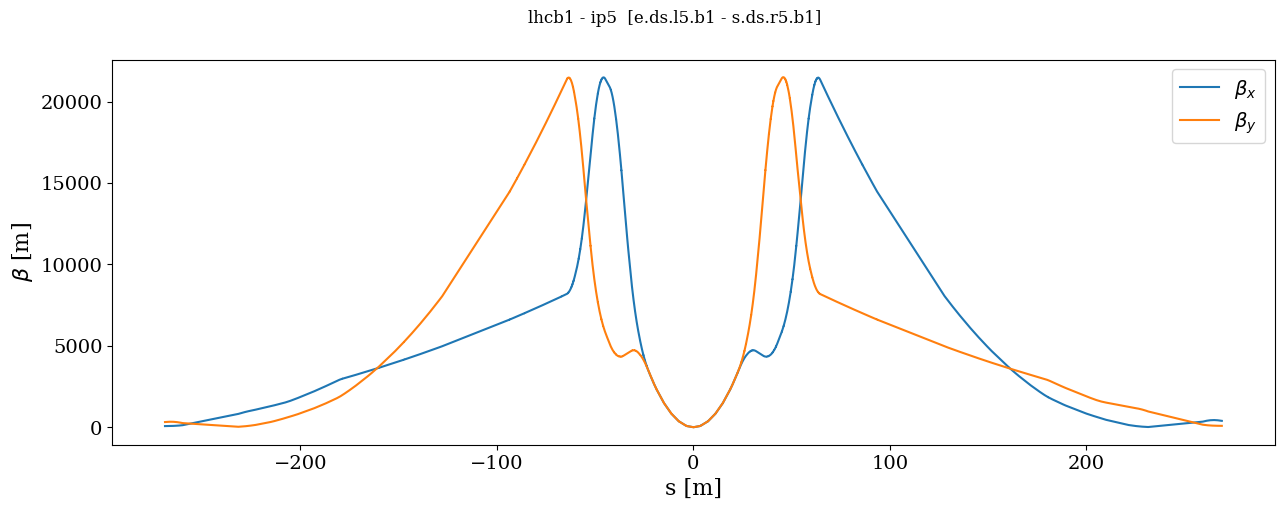

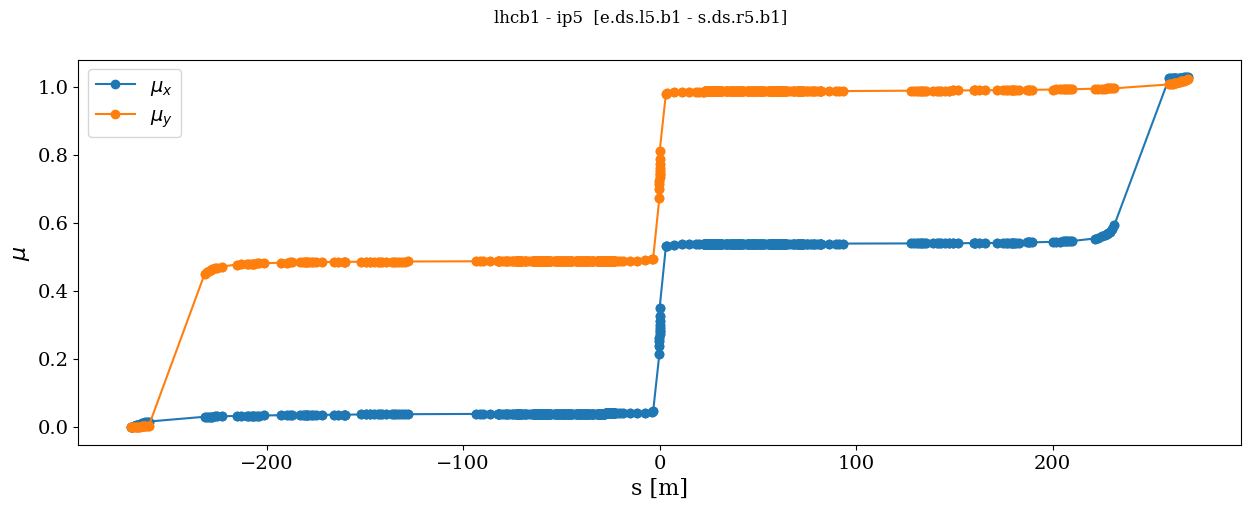

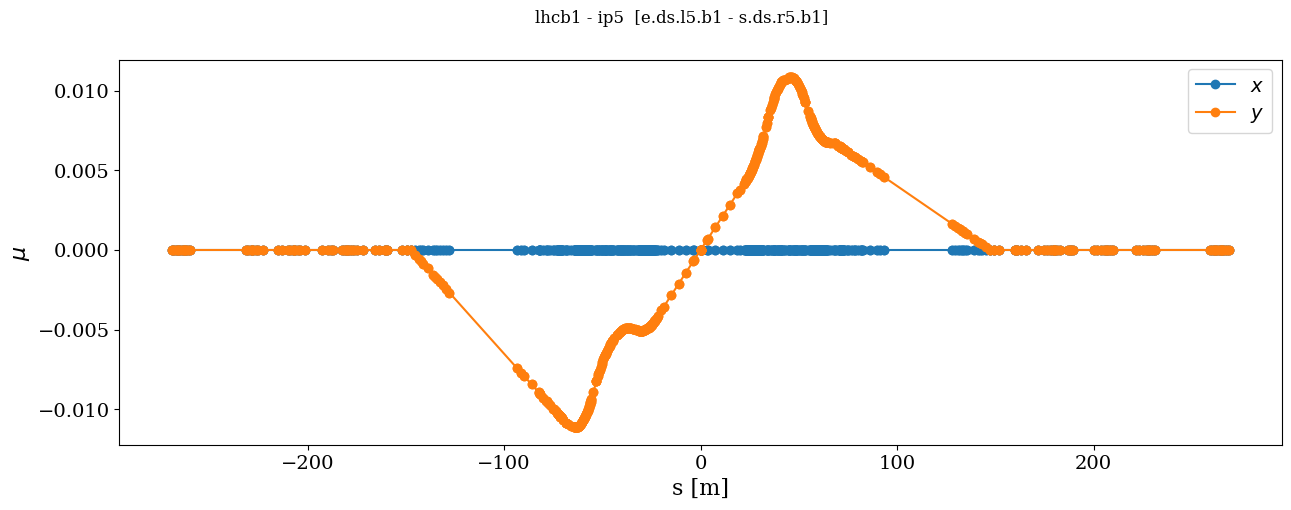

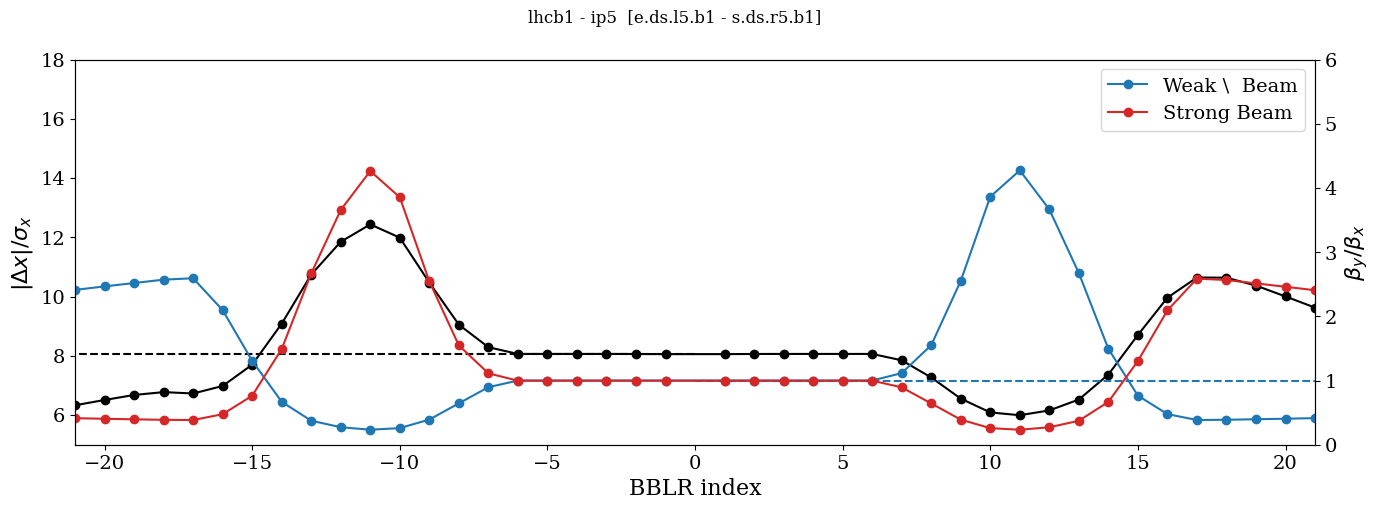

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import time 
import gc 
import os


import matplotlib.pyplot as plt
import matplotlib.colors as colors

# xsuite
import xtrack as xt
import xfields as xf
import xobjects as xo

# BBStudies
import BBStudies.Physics.Constants as cst
import BBStudies.Tracking.Buffers as xBuff
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.Utils as xutils
import BBStudies.Plotting.BBPlots as bbplt

import nafflib
from IPython.display import clear_output

# Matplotlib config
#============================
FIGPATH  = './'
FIG_W = 6
FIG_H = 6


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "xtick.labelsize":14,
    "ytick.labelsize":14,
    "axes.labelsize":16,
    "axes.titlesize":16,
    "legend.fontsize":14,
    "legend.title_fontsize":16
})
plt.rc('text.latex', preamble=r'\usepackage{physics}')
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"
#============================


collection  = 'CR_HL_data/output_collections_quick/outputs_190_V01/'
# collection  = 'old_CR_HL_data/output_collections_190/quick_V01/'


# collection  = 'CR_HL_data/output_collections_250_realspace/quick_V00/'
# collection  = 'CR_HL_data/V00_collections/outputs_V00/'

config_file = str(list(Path(collection).glob('*.yaml'))[0])
bblr_df,bbcw_df,twiss = get_bblr_bbcw_df(config_file)
config = xutils.read_YAML(config_file)
    # Parameters
#-------------------------------------
seq         = config['sequence']
ip_name     = config['ip']
disable_ho  = config['disable_ho']
# as_wires    = True

beam_name = seq[-2:]
s_marker  = config['s_marker']
e_marker  = config['e_marker']
#-------------------------------------
import json
print(40*'=')
print(json.dumps(config, sort_keys=False, indent=4))
print(40*'=')
#===================================
# PLOTTING TWISS
plt.figure(figsize=(15,5))
plt.suptitle(f'{seq} - {ip_name}  [{s_marker} - {e_marker}]')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.betx,label=r'$\beta_x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.bety,label=r'$\beta_y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]')


plt.figure(figsize=(15,5))
plt.suptitle(f'{seq} - {ip_name}  [{s_marker} - {e_marker}]')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.mux-twiss.mux[0],'-o',label=r'$\mu_x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.muy-twiss.muy[0],'-o',label=r'$\mu_y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\mu$ ')

plt.figure(figsize=(15,5))
plt.suptitle(f'{seq} - {ip_name}  [{s_marker} - {e_marker}]')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.x,'-o',label=r'$x$')
plt.plot(twiss.s-twiss.rows[ip_name].s,twiss.y,'-o',label=r'$y$')

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\mu$ ')

plt.figure(figsize=(16,5))
plt.suptitle(f'{seq} - {ip_name}  [{s_marker} - {e_marker}]')
if ip_name == 'ip1':
    plt.hlines(np.abs(bblr_df.loc[bblr_df.ID.abs().argmin()].dx_n),-22,0,ls='--',color='k')
    plt.plot(bblr_df.ID,np.abs(bblr_df.dx_n),'-o',color='k')
elif ip_name == 'ip5':
    plt.hlines(np.abs(bblr_df.loc[bblr_df.ID.abs().argmin()].dy_n),-22,0,ls='--',color='k')
    plt.plot(bblr_df.ID,np.abs(bblr_df.dy_n),'-o',color='k')

plt.ylim([5,18])
plt.xlim([-21,21])
plt.ylabel(rf'$|\Delta x|/\sigma_x$')
plt.xlabel(rf'BBLR index')
plt.gca().twinx()
plt.hlines(1,0,22,ls='--',color='C0')
plt.plot(bblr_df.ID,bblr_df.sigy_w**2/bblr_df.sigx_w**2,'-o',label='Weak \  Beam')
plt.plot(bblr_df.ID,bblr_df.sigy_s**2/bblr_df.sigx_s**2,'-o',color='C3',label='Strong Beam')
plt.legend()
plt.ylim([0,6])
plt.ylabel(rf'$\beta_y/\beta_x$')


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e as cst_elec
from scipy.constants import c as cst_c
from rich.progress import track as richtrack


# Finding critical residual
#==========================
df = pd.read_parquet(collection + '/OUT_JOB_0000.parquet')
# df = pd.read_parquet('./output_collections/outputs_V00/OUT_JOB_0000.parquet')
critical_DA  = 4.25
critical_roi = (np.abs(df.r - critical_DA) < 0.2)
DA_min = []
for _cr in df.residual[critical_roi]:
    # Estimating DA
    _DA_per_angle = []
    for name,group in df.groupby(pd.cut(df.angle,1000),observed=True):
        if np.any(group.residual>(_cr)):
            _DA_per_angle.append(np.min(group.r[group.residual>(_cr)]))
        else:
            _DA_per_angle.append(np.max(group.r))
    DA_min.append(np.min(np.array(_DA_per_angle)))
critical_res = np.array(df.residual[critical_roi])[np.argmin(np.abs(np.array(DA_min)-critical_DA))]
#==========================




file_list = sorted(list(Path(collection).glob('*.parquet')))


DA_min  = []
DA_avg  = []
Res_max = []
Iw_vec = []
dw_vec = []
for file in richtrack(file_list):
    df = pd.read_parquet(file)
    
    #Saving max residual
    _roi = (np.abs(df.r - 6) < 0.2)
    Res_max.append(np.max(df.residual[_roi]))

    # Estimating DA
    _DA_per_angle = []
    for name,group in df.groupby(pd.cut(df.angle,1000),observed=True):
        if np.any(group.residual>(critical_res)):
            _DA_per_angle.append(np.min(group.r[group.residual>(critical_res)]))
        else:
            _DA_per_angle.append(np.max(group.r))
    DA_min.append(np.min(np.array(_DA_per_angle)))
    DA_avg.append(np.mean(np.array(_DA_per_angle)))

    Iw_vec.append(df.Iw.unique()[0])
    if config['d_normalized']:
        dw_vec.append(df.dn.unique()[0])
    else:
        dw_vec.append(df.d.unique()[0])


DA_min = np.array(DA_min)
DA_avg = np.array(DA_avg)
Res_max = np.array(Res_max)
Iw_vec = np.array(Iw_vec)
dw_vec = np.array(dw_vec)



if not config['d_normalized']:
    dw_vec = dw_vec/1e-3




Output()

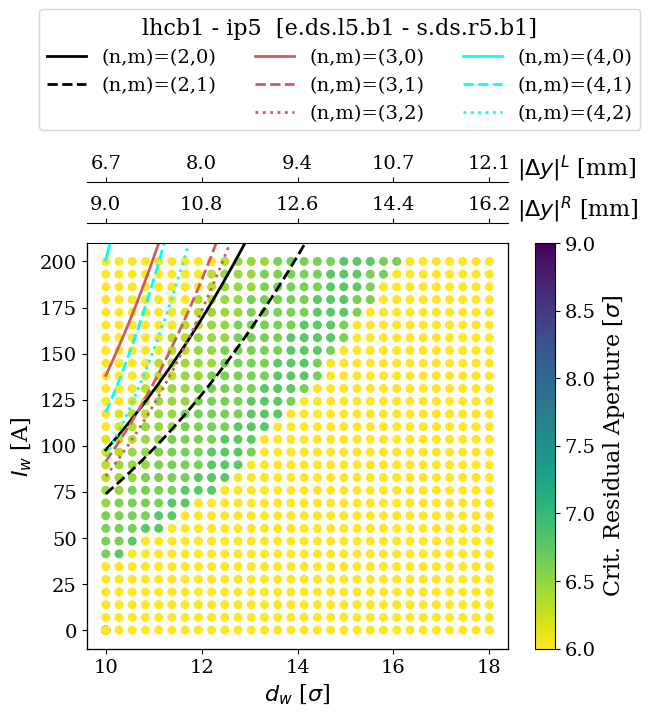

In [4]:

plt.figure(figsize=(6.5,5))
# plt.suptitle(f'{seq} - {ip_name}  [{s_marker} - {e_marker}]')

# plt.text(0.5, 0, f'{seq} - {ip_name}  [{s_marker} - {e_marker}]', horizontalalignment="center",verticalalignment="top",fontsize=12)
plt.scatter(dw_vec,Iw_vec,c=DA_min,cmap='viridis_r',s=30,vmin=6,vmax=9)
cbar = plt.colorbar(pad=0.05)

if config['d_normalized']:
    plt.xlabel(r'$d_w$ [$\sigma$]')
else:
    plt.xlabel(r'$d_w$ [mm]')
plt.ylabel(r'$I_w$ [A]')
cbar.set_label(r'Crit. Residual Aperture [$\sigma$]')

if config['d_normalized']:
    xlims = [9.6, 18.4]
else:
    xlims = [6, 17]
ylims = [-10.0, 210.0]
# ylims = [80.0, 520.0]
plt.xlim(xlims)
plt.ylim(ylims)

plt.tight_layout()
#====================



#===================================
# OVERLAYING CURVES

curves = [  (2,0),
            (2,1),
            (3,0),
            (3,1),
            (3,2),
            (4,0),
            (4,1),
            (4,2)]


if config['d_normalized']:
    d_curve = np.linspace(10,18,500)
else:
    d_curve = np.linspace(6.5,16.5,500)
color_dict = {2:'k',3:'indianred',4:'cyan'}
ls_dict = {0:'-',1:'--',2:':'}



c_list = []
for _n,_m in curves:
    C = 0
    if ip_name == 'ip1':
        for index,bblr_info in bblr_df.iterrows():
            C += bblr_info.other_beam_num_particles*(cst_elec*cst_c) * (bblr_info.bety/bblr_info.betx)**_m / np.abs(bblr_info.dx_n)**(_n+1)

        if config['d_normalized']:
            I_curve =  C*d_curve**(_n+1)/(np.sum(bbcw_df.rho**_m))
        else:
            I_curve =  C*(d_curve*1e-3)**(_n+1)/(np.sum(bbcw_df.rho**_m*bbcw_df.sigx**(_n+1)))
    elif ip_name == 'ip5':
        for index,bblr_info in bblr_df.iterrows():
            C += bblr_info.other_beam_num_particles*(cst_elec*cst_c) * (bblr_info.betx/bblr_info.bety)**_m / np.abs(bblr_info.dy_n)**(_n+1)
        if config['d_normalized']:
            I_curve =  C*d_curve**(_n+1)/(np.sum((1/bbcw_df.rho)**_m))
        else:
            I_curve =  C*(d_curve*1e-3)**(_n+1)/(np.sum((1/bbcw_df.rho)**_m*bbcw_df.sigy**(_n+1)))
    _c, = plt.plot(d_curve,I_curve,color=color_dict[_n],ls=ls_dict[_m],lw=2,alpha=1,label=f'(n,m)=({_n},{_m})')
    c_list.append(_c)

    if _n == 2 and _m == 1:
        plt.plot(np.nan,np.nan,color='k',ls='-',lw=2,alpha=0,label=f' ')

plt.legend(loc='upper center', bbox_to_anchor=(0.6, 1.6), ncol=3,title=f'{seq} - {ip_name}  [{s_marker} - {e_marker}]')
# #===================================

#===================================
# ADDING LEFT_RIGHT - DISTANCES
ax_n = plt.gca()

# LEFT WIRE
#------------------
ax_L = ax_n.twiny()
plt.xlim(xlims)
if ip_name == 'ip1':
    sigx = bbcw_df[bbcw_df.name.str.contains('4l')].sigx.min()
    sigy = bbcw_df[bbcw_df.name.str.contains('4l')].sigy.min()
    if config['d_normalized']:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x*sigx/1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta x|^{L}$ [mm]',labelpad=-15,ha='left',va='center',x=1.02)
    else:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x/sigx*1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta x|^{L}$ [$\sigma$]',labelpad=-15,ha='left',va='center',x=1.02)
elif ip_name == 'ip5':
    sigx = bbcw_df[bbcw_df.name.str.contains('4l')].sigx.min()
    sigy = bbcw_df[bbcw_df.name.str.contains('4l')].sigy.min()
    if config['d_normalized']:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x*sigy/1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta y|^{L}$ [mm]',labelpad=-15,ha='left',va='center',x=1.02)
    else:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x/sigy*1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta y|^{L}$ [$\sigma$]',labelpad=-15,ha='left',va='center',x=1.02)
#------------------

# RIGHT WIRE
#------------------
ax_R = ax_n.twiny()
plt.xlim(xlims)
if ip_name == 'ip1':
    sigx = bbcw_df[bbcw_df.name.str.contains('4r')].sigx.min()
    sigy = bbcw_df[bbcw_df.name.str.contains('4r')].sigy.min()
    if config['d_normalized']:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x*sigx/1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta x|^{R}$ [mm]',labelpad=-15,ha='left',va='center',x=1.02)
    else:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x/sigx*1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta x|^{R}$ [$\sigma$]',labelpad=-15,ha='left',va='center',x=1.02)
    #------------------
elif ip_name == 'ip5':
    sigx = bbcw_df[bbcw_df.name.str.contains('4r')].sigx.min()
    sigy = bbcw_df[bbcw_df.name.str.contains('4r')].sigy.min()
    if config['d_normalized']:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x*sigy/1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta y|^{R}$ [mm]',labelpad=-15,ha='left',va='center',x=1.02)
    else:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x/sigy*1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta y|^{R}$ [$\sigma$]',labelpad=-15,ha='left',va='center',x=1.02)
    #------------------

ax_L.xaxis.set_ticks_position("top")
ax_L.xaxis.set_label_position("top")
ax_R.xaxis.set_ticks_position("top")
ax_R.xaxis.set_label_position("top")


ax_L.spines["top"].set_position(("axes", 1.15))
ax_R.spines["top"].set_position(("axes", 1.05))

# plt.tight_layout()



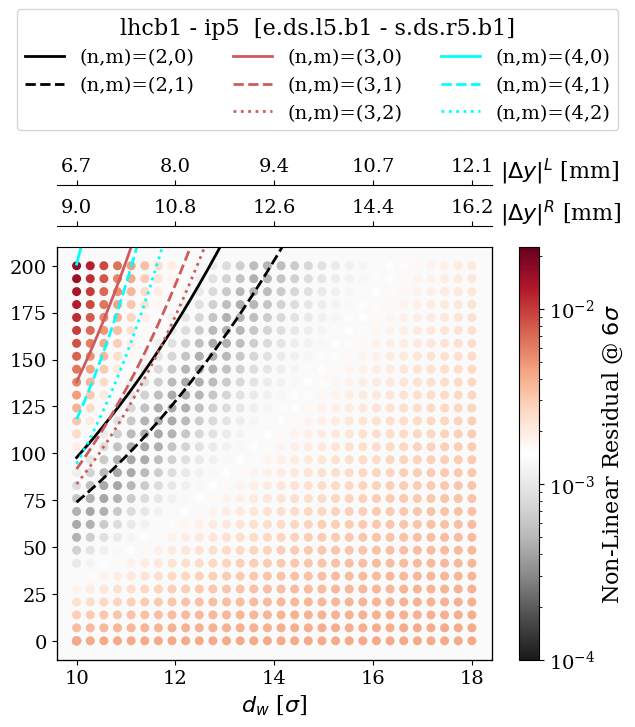

In [6]:

plt.figure(figsize=(6.5,5))
# plt.suptitle(f'{seq} - {ip_name}  [{s_marker} - {e_marker}]')

# plt.text(0.5, 0, f'{seq} - {ip_name}  [{s_marker} - {e_marker}]', horizontalalignment="center",verticalalignment="top",fontsize=12)

vcenter = 3e-4*5 # 50% LR
vmin    = 2e-5*5 # 10% LR

vmax = vcenter * vcenter/vmin
plt.scatter(dw_vec,Iw_vec,c=Res_max,cmap='RdGy_r',s=30, norm=colors.LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(pad=0.05)

if config['d_normalized']:
    plt.xlabel(r'$d_w$ [$\sigma$]')
else:
    plt.xlabel(r'$d_w$ [mm]')
cbar.set_label(r'Non-Linear Residual @ $6\sigma$')



if config['d_normalized']:
    xlims = [9.6, 18.4]
else:
    xlims = [6, 17]
ylims = [-10.0, 210.0]
# ylims = [80.0, 520.0]
plt.xlim(xlims)
plt.ylim(ylims)
plt.gca().set_facecolor('#fafafa')  # off-white background
plt.tight_layout()
#====================



#===================================
# OVERLAYING CURVES

curves = [  (2,0),
            (2,1),
            (3,0),
            (3,1),
            (3,2),
            (4,0),
            (4,1),
            (4,2)]


if config['d_normalized']:
    d_curve = np.linspace(10,18,500)
else:
    d_curve = np.linspace(6.5,16.5,500)
color_dict = {2:'k',3:'indianred',4:'cyan'}
ls_dict = {0:'-',1:'--',2:':'}



c_list = []
for _n,_m in curves:
    C = 0
    if ip_name == 'ip1':
        for index,bblr_info in bblr_df.iterrows():
            C += bblr_info.other_beam_num_particles*(cst_elec*cst_c) * (bblr_info.bety/bblr_info.betx)**_m / np.abs(bblr_info.dx_n)**(_n+1)

        if config['d_normalized']:
            I_curve =  C*d_curve**(_n+1)/(np.sum(bbcw_df.rho**_m))
        else:
            I_curve =  C*(d_curve*1e-3)**(_n+1)/(np.sum(bbcw_df.rho**_m*bbcw_df.sigx**(_n+1)))
    elif ip_name == 'ip5':
        for index,bblr_info in bblr_df.iterrows():
            C += bblr_info.other_beam_num_particles*(cst_elec*cst_c) * (bblr_info.betx/bblr_info.bety)**_m / np.abs(bblr_info.dy_n)**(_n+1)
        if config['d_normalized']:
            I_curve =  C*d_curve**(_n+1)/(np.sum((1/bbcw_df.rho)**_m))
        else:
            I_curve =  C*(d_curve*1e-3)**(_n+1)/(np.sum((1/bbcw_df.rho)**_m*bbcw_df.sigy**(_n+1)))
    _c, = plt.plot(d_curve,I_curve,color=color_dict[_n],ls=ls_dict[_m],lw=2,alpha=1,label=f'(n,m)=({_n},{_m})')
    c_list.append(_c)

    if _n == 2 and _m == 1:
        plt.plot(np.nan,np.nan,color='k',ls='-',lw=2,alpha=0,label=f' ')

plt.legend(loc='upper center', bbox_to_anchor=(0.6, 1.6), ncol=3,title=f'{seq} - {ip_name}  [{s_marker} - {e_marker}]')
# #===================================

#===================================
# ADDING LEFT_RIGHT - DISTANCES
ax_n = plt.gca()

# LEFT WIRE
#------------------
ax_L = ax_n.twiny()
plt.xlim(xlims)
if ip_name == 'ip1':
    sigx = bbcw_df[bbcw_df.name.str.contains('4l')].sigx.min()
    sigy = bbcw_df[bbcw_df.name.str.contains('4l')].sigy.min()
    if config['d_normalized']:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x*sigx/1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta x|^{L}$ [mm]',labelpad=-15,ha='left',va='center',x=1.02)
    else:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x/sigx*1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta x|^{L}$ [$\sigma$]',labelpad=-15,ha='left',va='center',x=1.02)
elif ip_name == 'ip5':
    sigx = bbcw_df[bbcw_df.name.str.contains('4l')].sigx.min()
    sigy = bbcw_df[bbcw_df.name.str.contains('4l')].sigy.min()
    if config['d_normalized']:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x*sigy/1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta y|^{L}$ [mm]',labelpad=-15,ha='left',va='center',x=1.02)
    else:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x/sigy*1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta y|^{L}$ [$\sigma$]',labelpad=-15,ha='left',va='center',x=1.02)
#------------------

# RIGHT WIRE
#------------------
ax_R = ax_n.twiny()
plt.xlim(xlims)
if ip_name == 'ip1':
    sigx = bbcw_df[bbcw_df.name.str.contains('4r')].sigx.min()
    sigy = bbcw_df[bbcw_df.name.str.contains('4r')].sigy.min()
    if config['d_normalized']:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x*sigx/1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta x|^{R}$ [mm]',labelpad=-15,ha='left',va='center',x=1.02)
    else:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x/sigx*1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta x|^{R}$ [$\sigma$]',labelpad=-15,ha='left',va='center',x=1.02)
    #------------------
elif ip_name == 'ip5':
    sigx = bbcw_df[bbcw_df.name.str.contains('4r')].sigx.min()
    sigy = bbcw_df[bbcw_df.name.str.contains('4r')].sigy.min()
    if config['d_normalized']:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x*sigy/1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta y|^{R}$ [mm]',labelpad=-15,ha='left',va='center',x=1.02)
    else:
        plt.xticks([_x for _x in plt.gca().get_xticks()][1:-1],
                [f'{_x/sigy*1e-3:.1f}' for _x in plt.gca().get_xticks()][1:-1])
        plt.xlabel(r'$|\Delta y|^{R}$ [$\sigma$]',labelpad=-15,ha='left',va='center',x=1.02)
    #------------------

ax_L.xaxis.set_ticks_position("top")
ax_L.xaxis.set_label_position("top")
ax_R.xaxis.set_ticks_position("top")
ax_R.xaxis.set_label_position("top")


ax_L.spines["top"].set_position(("axes", 1.15))
ax_R.spines["top"].set_position(("axes", 1.05))

# plt.tight_layout()

